<a href="https://colab.research.google.com/github/chrislitianxin/dl_playground/blob/master/kaggle_house_price_eda_lgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [205]:
!pip install kaggle
from google.colab import files

In [206]:
#uploaded = files.upload()
!mkdir /root/.kaggle
!chmod 600 /root/.kaggle/
!echo '{"username":"chrislitianxin","key":"bb6af6f582364ac9a1dddb9d8e5279fd"}' > /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
#!ls /root/.kaggle
#!mv kaggle.json /root/.kaggle

In [208]:
# !pip uninstall -y kaggle
# !pip install --upgrade pip
# !pip install kaggle==1.5.6
!kaggle competitions download -c house-prices-advanced-regression-techniques
!ls

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
data_description.txt: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
data_description.txt  sample_data  sample_submission.csv  test.csv  train.csv


In [0]:
#!unzip house-prices-advanced-regression-techniques.zip
#!cat data_description.txt

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [211]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print(df_train.shape,df_test.shape)

(1460, 81) (1459, 80)


In [212]:
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [213]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Skewness: 1.882876, Kurtosis: 6.536282


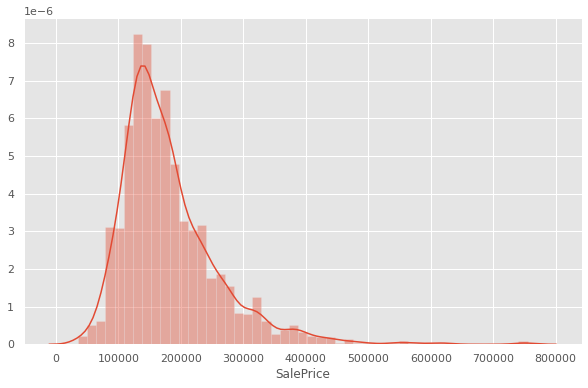

In [214]:
ax = sns.distplot(df_train['SalePrice'])
print('Skewness: %f, Kurtosis: %f' % (df_train['SalePrice'].skew(), df_train['SalePrice'].kurt()))

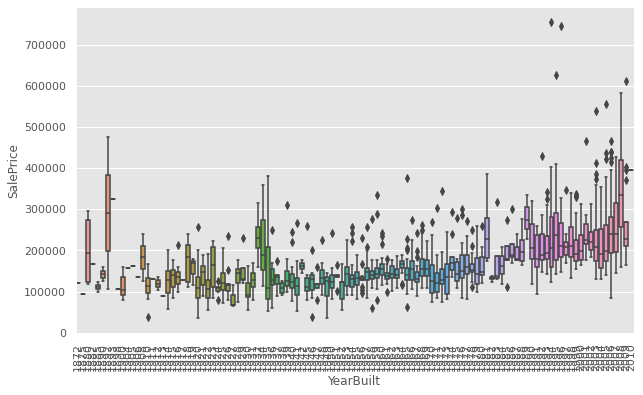

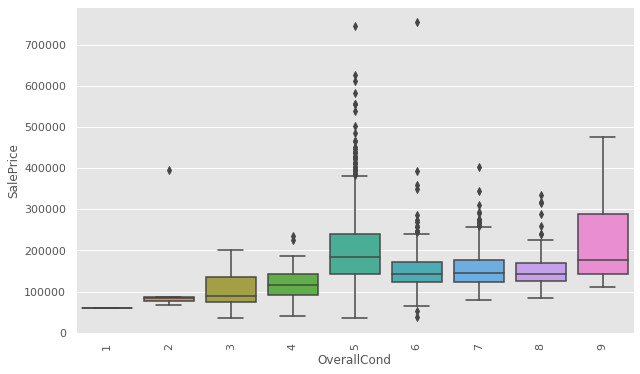

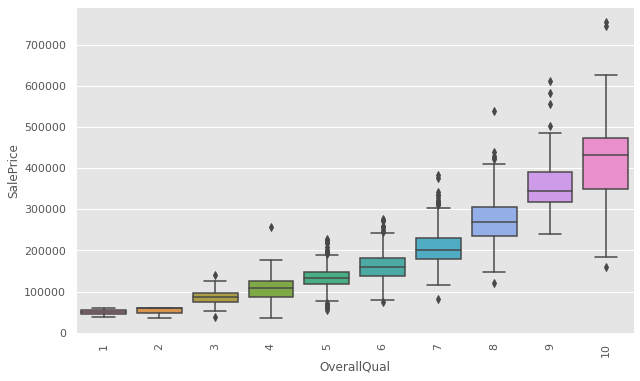

In [215]:
def boxplot_var(x,y):
  plot_data = pd.concat([df_train[x], df_train[y]], axis = 1)
  ax = sns.boxplot(x = x, y = y, data = plot_data)
  plt.xticks(rotation=90)
  plt.show()

boxplot_var('YearBuilt','SalePrice')
boxplot_var('OverallCond','SalePrice')
boxplot_var('OverallQual','SalePrice')

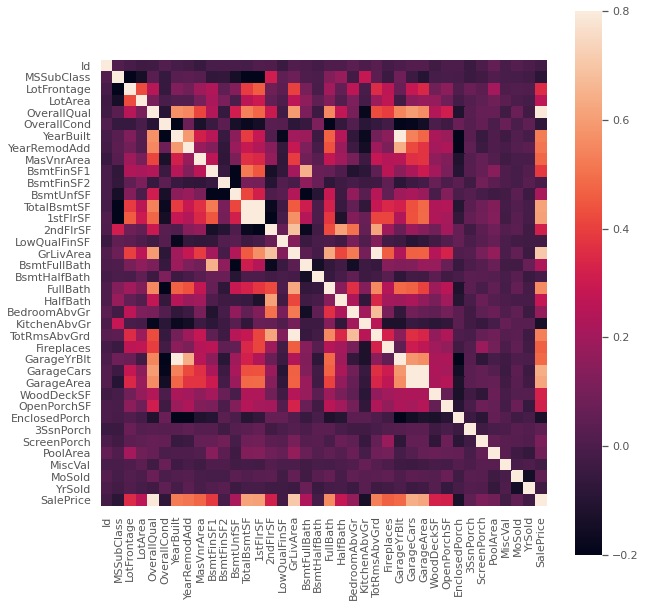

In [216]:
''' Correlation Matrix '''
corr_mat = df_train.corr()
plt.subplots(figsize = (10,10))
sns.heatmap(corr_mat, vmin = -0.2, vmax = 0.8, square = True, linewidths = 0, cbar = True)
plt.show()

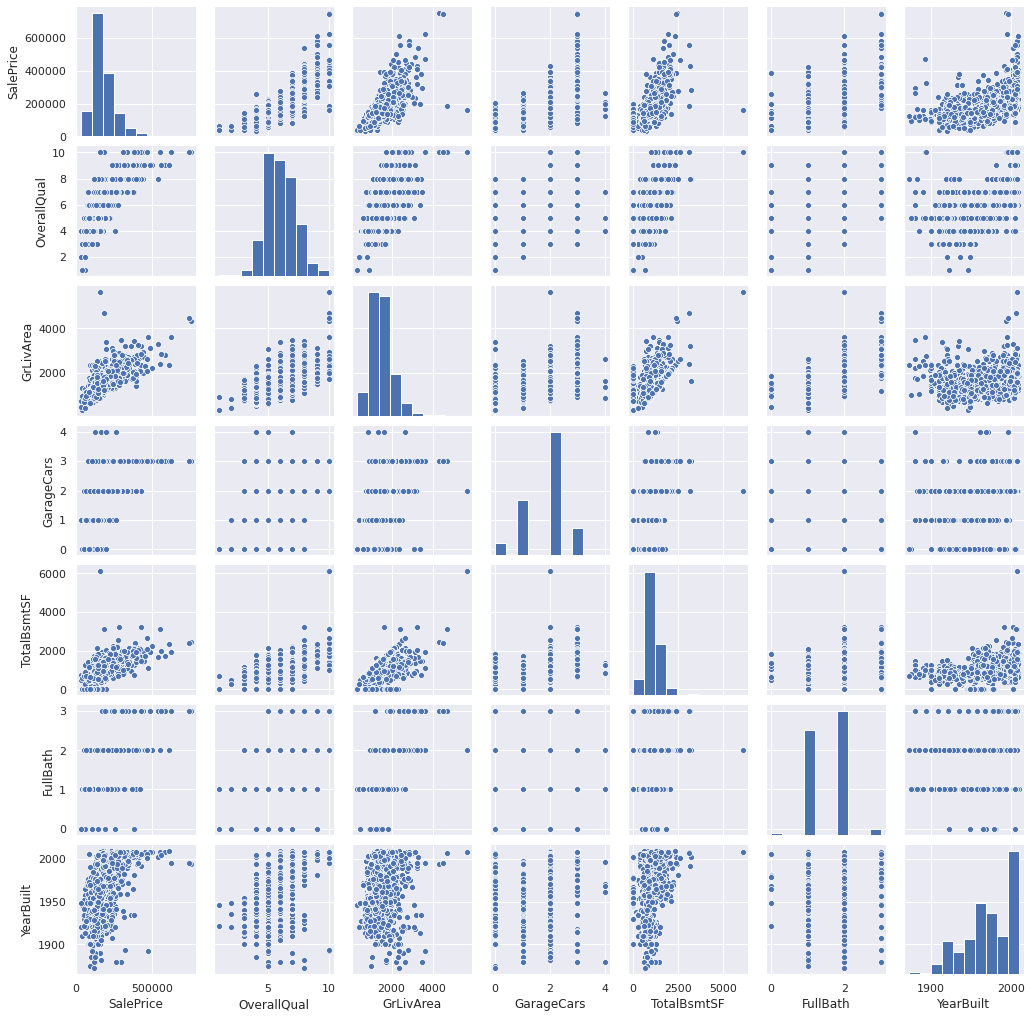

In [217]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2)
plt.show();

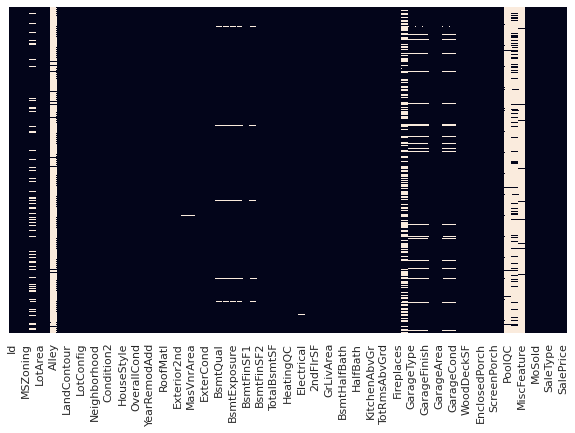

             Missing Ratio
PoolQC           99.520548
MiscFeature      96.301370
Alley            93.767123
Fence            80.753425
FireplaceQu      47.260274


In [218]:
def miss_ratio(data):
  datana = (data.isnull().sum() / len(data)) * 100
  datana = datana.drop(datana[datana == 0].index).sort_values(ascending=False)
  missing_data = pd.DataFrame({'Missing Ratio' :datana})
  print(missing_data.head())
  
nullCols = df_train.isnull().sum() / len(df_train)
nullCols = nullCols.sort_values(ascending=False)
nullCols = nullCols[nullCols > 0.1]
sns.heatmap(df_train.isnull(), yticklabels = False, cbar = False)
plt.show()
# showing null values
miss_ratio(df_train)

**Preprocessing**

In [0]:
# Handle Null Values 
def fillnaCols(data, cols, val):
    for col in cols:
       data[col].fillna(val, inplace=True)
    

# These values are likely none as most houses doesn't have those
noneCols = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']

# These values are missing because likely there is no garage
noneCols += ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'] 
# no basement 
zeroCols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
zeroCols += ['GarageYrBlt', 'GarageArea', 'GarageCars']
# no masonry veneer
noneCols += ['MasVnrType']
noneCols += ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
zeroCols += ['MasVnrArea']

# cols to drop
dropCols = ['Id','Utilities']

# cols to fill with mode 
commonCols = ['Exterior1st','Exterior2nd','Electrical','SaleType','MSZoning']

def handleNull(data):
    fillnaCols(data, noneCols, 'None')
    fillnaCols(data, zeroCols, 0)
    fillnaCols(data, commonCols, lambda x: x.mode()[0])

    for col in dropCols:
        data.drop(col, axis = 1, inplace=True)

    # fill in missing values by the median LotFrontage of the neighbourhood
    # !Clever choice: taken from kaggle notebook by Serigne
    # https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
    data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(
        lambda x: x.fillna(x.median())) 
    data['Functional']  = data['Functional'].fillna('Typ')
    
handleNull(df_train)
handleNull(df_test)

**Remove Outliers** 

could use leave-one-out to find out outliers, but realistically don't use it as it's expensive

In [0]:
outliers = [30, 88, 462, 631, 1322]
df_train = df_train.drop(df_train.index[outliers])

In [0]:
# seperate x/y
y_train = df_train['SalePrice'].values
df_train = df_train.drop('SalePrice',axis=1)

In [222]:
miss_ratio(df_train)
df_train['LotFrontage'].describe()
print(df_train.shape)

Empty DataFrame
Columns: [Missing Ratio]
Index: []
(1455, 78)


Finding columns that could require a log norm transformation if linear model is to be fitted as linear model fit for normally distributed data. 

In [223]:
from scipy.special import boxcox1p
from scipy.stats import norm, skew 
numeric_feats = df_train.dtypes[df_train.dtypes != "object"].index
skewed_feats = df_train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats

MiscVal          24.409802
PoolArea         14.787402
LotArea          12.177922
3SsnPorch        10.275636
LowQualFinSF      9.244556
KitchenAbvGr      4.474988
BsmtFinSF2        4.254856
ScreenPorch       4.109754
BsmtHalfBath      4.090953
EnclosedPorch     3.124642
MasVnrArea        2.669734
OpenPorchSF       2.359062
LotFrontage       2.225134
BsmtFinSF1        1.683507
WoodDeckSF        1.540846
TotalBsmtSF       1.522241
MSSubClass        1.408196
1stFlrSF          1.375776
GrLivArea         1.365509
BsmtUnfSF         0.922573
2ndFlrSF          0.812670
dtype: float64

In [0]:
# for feat in skewed_feats.index:
#     sns.distplot(df_train[feat], fit=norm)
#     plt.show()

**Removing Outliers to prevent overfitting**


Leave-ONE-Out emthods with OLS 

Not realistic in real world usage as it is super expensive 

**One-Hot Encoding**

sicne get_dummies only applies one hot encoding on string features, we need to transfrom some int categorical features to string  

In [225]:
def prep_dummies(data):
  int_cat_cols = ['MSSubClass','OverallCond','YrSold','MoSold']
  for col in int_cat_cols:
    data[col] = data[col].astype(str)

n_train,n_test = df_train.shape[0],df_test.shape[0]
data = pd.concat((df_train,df_test),axis = 0)
prep_dummies(data)
print('Before one hot: ', data.shape)

# One hot encoding 
data = pd.get_dummies(data)
print('After one hot: ',data.shape)
x_train = data[:n_train].values
x_test = data[n_train:].values
print(y_train.shape,x_train.shape,x_test.shape)

Before one hot:  (2914, 78)
After one hot:  (2914, 343)
(1455,) (1455, 343) (1459, 343)


**Log-transformation on y**

to make sale price normaly distributed 


 mu = 12.03 and sigma = 0.40



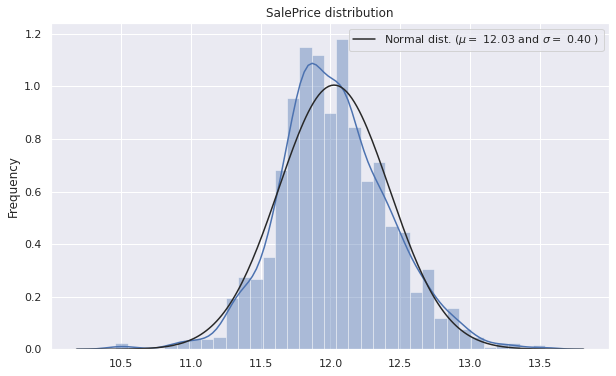

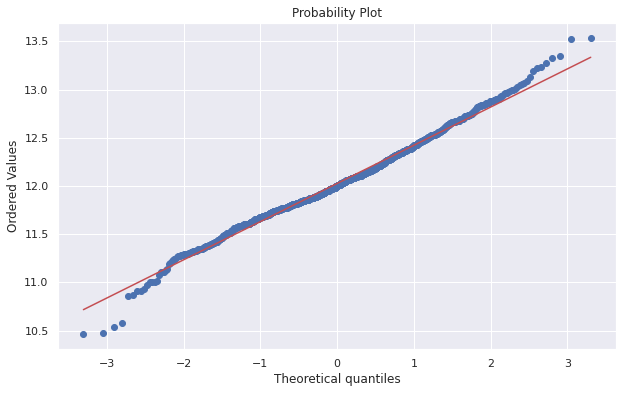

In [226]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
y_train = np.log1p(y_train)

#Check the new distribution 
sns.distplot(y_train , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

**Models**

In [0]:
import lightgbm as lgb 
from sklearn.model_selection import KFold, cross_val_score, train_test_split
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [0]:
n_folds = 5
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
def rmsle_cv(model,x,y):
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", 
                                   cv = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x)))
    return(rmse)

**Light Gradient Boosting**

In [248]:
score = rmsle_cv(model_lgb,x_train,y_train)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))
score

LGBM score: 0.1213 (0.0106)



array([0.10245888, 0.12761378, 0.12888895, 0.1166219 , 0.1308546 ])

**Lasso**

In [0]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [0]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [249]:
score = rmsle_cv(lasso,x_train,y_train)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score


Lasso score: 0.1321 (0.0308)



array([0.09565669, 0.14129363, 0.13002924, 0.10868062, 0.18488181])

**Gradient Boosting**

In [0]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [250]:
score = rmsle_cv(GBoost,x_train,y_train)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score

Gradient Boosting score: 0.1214 (0.0153)



array([0.09939599, 0.13973665, 0.13009596, 0.10770227, 0.13030441])

The lasso regression base model should perform much worse than GB and LGB models as the features are not normalized. Next I need to test whether PCA will help reduce variance in the RMSLE

In [0]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x_train_sd = ss.fit_transform(x_train)

In [0]:
from sklearn.decomposition import PCA
pca = PCA(200)
x_train_pca = pca.fit_transform(x_train_sd)
pca.get_covariance()
explained_variance=pca.explained_variance_ratio_

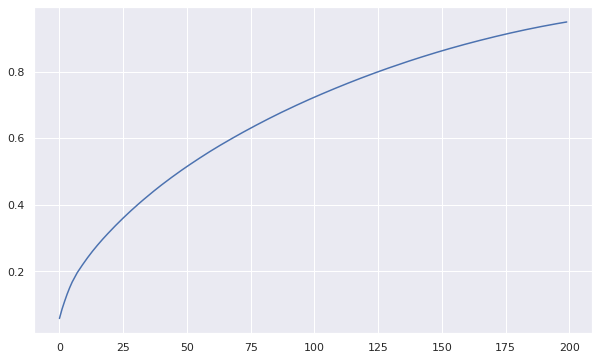

In [271]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
# so we can cap component at 200 at roughly 90%, rest is ineffective

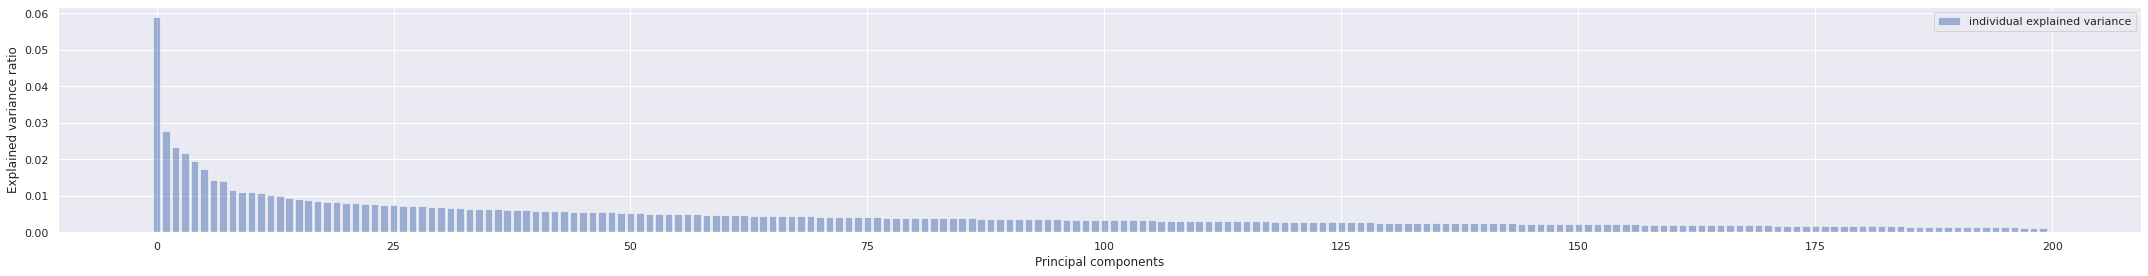

In [273]:
plt.figure(figsize=(30, 4))

plt.bar(range(200), explained_variance, alpha=0.5, align='center',
        label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

In [0]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [275]:
score = rmsle_cv(model_lgb,x_train_pca,y_train)
print("LGB score after PCA: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score

LGB score after PCA: 0.1464 (0.0164)



array([0.11899538, 0.1577473 , 0.16625751, 0.1385811 , 0.15040104])

**Hyperparam Tunning**

In [278]:
!pip install optuna

     |████████████████████████████████| 153kB 4.8MB/s 
     |████████████████████████████████| 1.1MB 48.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 81kB 10.9MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 112kB 53.9MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=c3f3c77b164eabc9e4c5b977bfc73612f178eb2f34f2d1bdea1071d35ef7ccf2
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-1.2.0-cp36-none-any.whl size=204611 sha256=12d2eaed9c28f31fd4c570ad84fbfe26e9c57ea9e475c311a015859de683f1a4
  Stored in directory: /root/.cache/pip/wheels/74/

In [285]:

import optuna.integration.lightgbm as lgb

params = {  "objective": "regression",
            "metric": "rmse",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "early_stopping_rounds": 50
    }
x_t = lgb.Dataset(x_train_pca[:-200],y_train[:-200])
x_val = lgb.Dataset(x_train_pca[-200:],y_train[-200:])

best_params, tuning_history = dict(), list()
booster = lgb.train(params, x_t, valid_sets=x_val,
                    verbose_eval=0,
                    num_boost_round=1000,
                    best_params=best_params,
                    tuning_history=tuning_history)
 
print('Best Params:', best_params)
print('Tunning history', tuning_history)






  0%|          | 0/7 [00:00<?, ?it/s]




tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]




tune_feature_fraction, val_score: 0.154817:   0%|          | 0/7 [00:08<?, ?it/s]




tune_feature_fraction, val_score: 0.154817:  14%|#4        | 1/7 [00:08<00:50,  8.48s/it][I 2020-03-23 22:25:10,018] Finished trial#0 resulted in value: 0.15481732366457396. Current best value is 0.15481732366457396 with parameters: {'feature_fraction': 0.4}.





tune_feature_fraction, val_score: 0.154817:  14%|#4        | 1/7 [00:08<00:50,  8.48s/it]




tune_feature_fraction, val_score: 0.154817:  14%|#4        | 1/7 [00:14<00:50,  8.48s/it]




tune_feature_fraction, val_score: 0.154817:  29%|##8       | 2/7 [00:14<00:39,  7.88s/it][I 2020-03-23 22:25:16,516] Finished trial#1 resulted in value: 0.1551824054126913. Current best value is 0.15481732366457396 with parameters: {'feature_fraction': 0.4}.





tune_feature_fraction, val_score: 0.154817:  29%|##8       | 2/7 [00:

Best Params: {'lambda_l1': 1.3816923455069667e-05, 'lambda_l2': 4.09485094134888e-08, 'num_leaves': 33, 'feature_fraction': 0.716, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
Tunning history [{'action': 'tune_feature_fraction', 'trial': 0, 'value': "{'feature_fraction': 0.4}", 'val_score': 0.15481732366457396, 'elapsed_secs': 8.466525793075562, 'average_iteration_time': 0.018940773586298795}, {'action': 'tune_feature_fraction', 'trial': 1, 'value': "{'feature_fraction': 0.5}", 'val_score': 0.1551824054126913, 'elapsed_secs': 6.336002349853516, 'average_iteration_time': 0.024558148642843083}, {'action': 'tune_feature_fraction', 'trial': 2, 'value': "{'feature_fraction': 0.6}", 'val_score': 0.15041090295138396, 'elapsed_secs': 7.3862624168396, 'average_iteration_time': 0.02990389642445182}, {'action': 'tune_feature_fraction', 'trial': 3, 'value': "{'feature_fraction': 0.7}", 'val_score': 0.14632117548927753, 'elapsed_secs': 5.0741376876831055, 'average_iteration_